<a href="https://colab.research.google.com/github/AshkanSamavatian/Thesis/blob/main/Thesis_10th_(T5_and_Comparison).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installing and Importing Required Libraries**



In [ ]:
#Installing required libraries for the project
!pip install -q transformers datasets evaluate torch
!pip install -U transformers
!pip install -q datasets
!pip install -q bert-score
!pip install -q git+https://github.com/google-research/bleurt.git
!pip install -q nlpaug
!pip install -q tabulate
!pip install -q torch transformers datasets accelerate

#Importing fundamental libraries for the project
import os
import shutil
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import json
import transformers
from google.colab import files, drive
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_dataset
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, DataCollatorWithPadding, DataCollatorForLanguageModeling, Trainer, EarlyStoppingCallback, AutoModelForMaskedLM, pipeline, T5ForConditionalGeneration, T5Tokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
from evaluate import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from scipy.stats import ttest_ind, wilcoxon
from torch.nn import CrossEntropyLoss
import nlpaug.augmenter.word as naw
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tabulate import tabulate
os.environ["WANDB_DISABLED"]="true"
torch.autograd.set_detect_anomaly(True)
%env CUDA_LAUNCH_BLOCKING=1
transformers.utils.logging.set_verbosity_error()

#Defining a reproducibility function
def set_seed(seed=101):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True  #Ensuring deterministic behavior
    torch.backends.cudnn.benchmark=False  #Disabling automatic optimizations

#Setting seed globally
set_seed(101)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### **Importing, Reviewing, and Preparing FLUTE Dataset for the Project**

In [ ]:
#Importing the FLUTE dataset
uploaded=files.upload()

#Reading and storing the FLUTE dataset
flute_df=pd.read_csv("train.csv")

#Overviewing the FLUTE dataset
flute_df.info()

Saving train.csv to train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7534 entries, 0 to 7533
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7534 non-null   int64 
 1   premise      7534 non-null   object
 2   hypothesis   7534 non-null   object
 3   label        7534 non-null   object
 4   explanation  7530 non-null   object
 5   split        7534 non-null   object
 6   type         7534 non-null   object
 7   idiom        1768 non-null   object
dtypes: int64(1), object(7)
memory usage: 471.0+ KB


In [ ]:
#Monitoring the FLUTE dataset
flute_df.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,1,I left my adult son home for a few days and ju...,I was gone for only a few days and my consider...,Contradiction,Most people would not consider leaving dirty d...,train,Sarcasm,NaN
1,2,I just caught a guy picking up used chewing gu...,it was such a pleasant sight to see a guy pick...,Contradiction,Picking up used chewing gum is really unhygien...,train,Sarcasm,NaN
2,3,You could feel their sudden appearance in the ...,Their sudden appearance in the farmhouse was l...,Entailment,A gust of arctic wind is an icy blast that is ...,train,Simile,NaN
3,4,"April's had never left, perfectly white and fu...","April's had never left, like a toothpaste comm...",Entailment,A toothpaste commercial is something that is a...,train,Simile,NaN
4,5,I cooked a meal for family and it came out hor...,I feel terrible that the meal I cooked for my ...,Entailment,It is often very embarrassing when someone coo...,train,CreativeParaphrase,NaN


In [ ]:
#Defining a function to analyze and review the columns in the FLUTE dataset
def analyze_columns(dataframe, columns):
    """
    Analyze specified columns of a DataFrame by providing the number of unique values
    and the value counts for each column.
    Args:
        dataframe (pd.DataFrame): The DataFrame to analyze.
        columns (list): List of column names to analyze.
    Returns:
        dict: A dictionary where each key is a column name, and the value is a tuple
              (number_of_unique_values, value_counts_series).
    """
    analysis_results={}
    for column in columns:
        if column in dataframe.columns:
            unique_count=len(set(dataframe[column]))
            value_counts=dataframe[column].value_counts()
            analysis_results[column]=(unique_count, value_counts)
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame.")
    return analysis_results

#Reviewing the "type", "label", "premise", "hypothesis", and "explanation" columns in the FLUTE dataset
results=analyze_columns(flute_df, ["type", "label", "premise", "hypothesis", "explanation"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-"*50)

Column: type
Number of unique values: 5
Value counts:
type
Sarcasm               2216
Idiom                 1768
Simile                1250
Metaphor              1250
CreativeParaphrase    1050
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    4350
Entailment       3184
Name: count, dtype: int64
--------------------------------------------------
Column: premise
Number of unique values: 5492
Value counts:
premise
I am worried I will not be able to go to my fathers birthday party.                                            6
I've been hearing some strange noises around the house at night.                                               6
I was really stressed out and grad school and had no choice but to drop out to keep my sanity.                 6
I missed my flight that I paid heavily for, I was so annoyed                                                   6
I found drugs in my son's r

In [ ]:
#Defining the validation size
validation_size=0.2

#Spliting the FLUTE dataset into training and validation sets
flute_train, flute_val=train_test_split(flute_df, test_size=validation_size, random_state=101)

#Checking the sizes of the splits
print(f"FLUTE Training set size: {len(flute_train)}")
print(f"FLUTE Validation set size: {len(flute_val)}")

FLUTE Training set size: 6027
FLUTE Validation set size: 1507


In [ ]:
#Overviewing the FLUTE Training set
flute_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6027 entries, 2279 to 4959
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6027 non-null   int64 
 1   premise      6027 non-null   object
 2   hypothesis   6027 non-null   object
 3   label        6027 non-null   object
 4   explanation  6023 non-null   object
 5   split        6027 non-null   object
 6   type         6027 non-null   object
 7   idiom        1416 non-null   object
dtypes: int64(1), object(7)
memory usage: 423.8+ KB


In [ ]:
#Monitoring the FLUTE Training set
flute_train.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
2279,2280,Some unintelligent and unsuccessful young pers...,Some bright young thing had gotten ahold of a ...,Contradiction,A bright young thing is a young person who is ...,train,Idiom,bright young thing
1308,1309,"Once now remember, this is a vacation, not car...","Once now remember, this is a vacation, not car...",Contradiction,To run amok means to go awry or to act out of ...,train,Idiom,run amok
6921,6922,Now he feels agitated,Now he feels like a high mountain lake without...,Contradiction,A mountain lake without any wind stirring it i...,train,Simile,NaN
4155,4156,I had a box chocolate when my doctor advised a...,I broke my diet by eating a box of chocolates ...,Contradiction,A diet is often broken when someone eats somet...,train,Sarcasm,NaN
6323,6324,"It wasn't glib or run of the mill ,it wasn't i...","It wasn't glib or run of the mill ,it didn't g...",Entailment,The idiom in one ear and out the other is used...,train,Idiom,in one ear and out the other


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE training set
results=analyze_columns(flute_train, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-"*50)

Column: type
Number of unique values: 5
Value counts:
type
Sarcasm               1759
Idiom                 1416
Metaphor              1014
Simile                1005
CreativeParaphrase     833
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    3478
Entailment       2549
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Overviewing the FLUTE Validation set
flute_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1507 entries, 4822 to 3176
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1507 non-null   int64 
 1   premise      1507 non-null   object
 2   hypothesis   1507 non-null   object
 3   label        1507 non-null   object
 4   explanation  1507 non-null   object
 5   split        1507 non-null   object
 6   type         1507 non-null   object
 7   idiom        352 non-null    object
dtypes: int64(1), object(7)
memory usage: 106.0+ KB


In [ ]:
#Monitoring the FLUTE Validation set
flute_val.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
4822,4823,My boss suddenly just took that project I was ...,I'm so glad my boss just took that project I h...,Contradiction,The boss taking a project away from an employ...,train,Sarcasm,NaN
6862,6863,Clementine was pinned securely,Clementine was pinned like a butterfly in a gl...,Entailment,A butterfly in a glass case is pinned down and...,train,Simile,NaN
1571,1572,"Once we commit to a significant response, it n...","Once we commit to a significant response, it n...",Entailment,"To bear fruit means to yield results, so in th...",train,Idiom,bear fruit
3293,3294,"He was about sixty, short and fat .","He was about sixty, like a big soccer ball .",Entailment,"A soccer ball is short and fat, so the simile ...",train,Simile,NaN
4713,4714,"The overhead light buzzed soothingly, at the e...",The overhead light buzzed at the edge of heari...,Contradiction,"Flies buzz irritatingly, not soothingly",train,Simile,NaN


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE validation set
results=analyze_columns(flute_val, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-"*50)

Column: type
Number of unique values: 5
Value counts:
type
Sarcasm               457
Idiom                 352
Simile                245
Metaphor              236
CreativeParaphrase    217
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    872
Entailment       635
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Importing the FLUTE test set
uploaded=files.upload()

#Reading and storing the FLUTE test set
test_df=pd.read_csv("test2.csv")

#Overviewing the FLUTE test set
test_df.info()

Saving test2.csv to test2.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1498 non-null   int64 
 1   premise      1498 non-null   object
 2   hypothesis   1498 non-null   object
 3   label        1498 non-null   object
 4   explanation  1498 non-null   object
 5   split        1498 non-null   object
 6   type         1498 non-null   object
 7   idiom        250 non-null    object
dtypes: int64(1), object(7)
memory usage: 93.8+ KB


In [ ]:
#Monitoring the FLUTE test set
test_df.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,1,I went to a buffet the other day and they kick...,I felt amazing when the buffet staff threw me ...,Contradiction,Being thrown out of a buffet for eating too mu...,test,Sarcasm,NaN
1,2,"Because I know Ronin's confidantes, and they w...","Because I know Ronin's confidantes, and they w...",Entailment,To tell tales out of school means to share sec...,test,Idiom,tell tales out of school
2,3,"I just broke up with my girlfriend, we were to...",Loving this life of loneliness after breaking ...,Contradiction,Loneliness is not a desirable feeling and is o...,test,Sarcasm,NaN
3,4,The government allowed the value of the ruble ...,The government floated the ruble for a few mon...,Entailment,Floating the ruble means that the government a...,test,Metaphor,NaN
4,5,Another girl was flirting with my boyfriend at...,I really felt cooperative when I saw another g...,Contradiction,Seeing someone else flirt with your boyfriend ...,test,Sarcasm,NaN


In [ ]:
#Reviewing the "type", "label", "premise", "hypothesis", and "explanation" columns in the FLUTE test set
results=analyze_columns(test_df, ["type", "label", "premise", "hypothesis", "explanation"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-"*50)

Column: type
Number of unique values: 4
Value counts:
type
Sarcasm     750
Idiom       250
Simile      250
Metaphor    248
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    835
Entailment       663
Name: count, dtype: int64
--------------------------------------------------
Column: premise
Number of unique values: 1186
Value counts:
premise
The kitchen was a total mess with old pile up of dishes and dried up food on the stove.                    3
When my boyfriend left me for another woman on Valentine's Day that really sucked being left all alone.    3
My landlord takes rent but he doesn't want to make any reparations.                                        3
My dishwasher leaked and we had to have our whole kitchen and living room redone due to the damages.       3
I can't get pregnant but all my friends are having kids.                                                   3
       

In [ ]:
#Removing rows where the type column equals CreativeParaphrase
flute_df=flute_df[flute_df["type"]!="CreativeParaphrase"]

#Reseting the index after filtering to keep the indexes clean
flute_df.reset_index(drop=True, inplace=True)

#Overviewing the refiend FLUTE dataset
print(flute_df.info())

#Confirming the rows are removed by checking the value counts in the type column
print(flute_df["type"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6484 entries, 0 to 6483
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6484 non-null   int64 
 1   premise      6484 non-null   object
 2   hypothesis   6484 non-null   object
 3   label        6484 non-null   object
 4   explanation  6480 non-null   object
 5   split        6484 non-null   object
 6   type         6484 non-null   object
 7   idiom        1768 non-null   object
dtypes: int64(1), object(7)
memory usage: 405.4+ KB
None
type
Sarcasm     2216
Idiom       1768
Simile      1250
Metaphor    1250
Name: count, dtype: int64


In [ ]:
#Spliting the refiend FLUTE dataset into training and validation sets
flute_train, flute_val=train_test_split(flute_df, test_size=validation_size, random_state=101)

#Checking the sizes of the splits
print(f"FLUTE Training set size: {len(flute_train)}")
print(f"FLUTE Validation set size: {len(flute_val)}")

FLUTE Training set size: 5187
FLUTE Validation set size: 1297


In [ ]:
#Overviewing the refiend FLUTE Training set
flute_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5187 entries, 5183 to 4959
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5187 non-null   int64 
 1   premise      5187 non-null   object
 2   hypothesis   5187 non-null   object
 3   label        5187 non-null   object
 4   explanation  5183 non-null   object
 5   split        5187 non-null   object
 6   type         5187 non-null   object
 7   idiom        1400 non-null   object
dtypes: int64(1), object(7)
memory usage: 364.7+ KB


In [ ]:
#Monitoring the refiend FLUTE Training set
flute_train.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
5183,6025,I think that one person working alone can achi...,I always believe that two heads are better tha...,Contradiction,The idiom two heads are better than one means ...,train,Idiom,two heads are better than one
1648,1941,She tended to be loud when speaking into a mic...,She tended to blast when speaking into a micro...,Entailment,blast means to speak loudly.,train,Metaphor,NaN
5012,5828,I am so annoyed by my new manager at work beca...,I just love the fact that my new manager at wo...,Contradiction,Having a new manager who is dishonest and untr...,train,Sarcasm,NaN
4470,5190,Even though it had two legs and arms like a hu...,It balanced on two asymmetrical legs and had a...,Entailment,"A scarecrow is a crude imitation of a human, m...",train,Simile,NaN
4844,5632,The event left her memory.,The event engraved itself into her memory.,Contradiction,The word engraved refers something that is per...,train,Metaphor,NaN


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE Training set after refining
results=analyze_columns(flute_train, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-"*50)

Column: type
Number of unique values: 4
Value counts:
type
Sarcasm     1789
Idiom       1400
Simile      1007
Metaphor     991
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    3481
Entailment       1706
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Overviewing the refiend FLUTE Validation set
flute_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1782 to 461
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1297 non-null   int64 
 1   premise      1297 non-null   object
 2   hypothesis   1297 non-null   object
 3   label        1297 non-null   object
 4   explanation  1297 non-null   object
 5   split        1297 non-null   object
 6   type         1297 non-null   object
 7   idiom        368 non-null    object
dtypes: int64(1), object(7)
memory usage: 91.2+ KB


In [ ]:
#Monitoring the refiend FLUTE Validation set
flute_val.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
1782,2092,"My friend Karl had a party, he invited a lot o...",I feel so cherished that my loyal friend Karl ...,Contradiction,Being left out of a party organized by a close...,train,Sarcasm,NaN
4697,5460,"Even though the exterior was small, the interi...",The interior was far bigger than its exterior ...,Contradiction,A rail-road tunnel through a mountain would ha...,train,Simile,NaN
3100,3607,"Every day, I had not nothing but not showing ...","Every day, I had done nothing but walk on eggs...",Contradiction,To walk on eggshells around someone means to a...,train,Idiom,walk on eggshells
6435,7482,The grove only takes the top thirty drama cand...,The grove only takes the top thirty drama cand...,Entailment,To put your best foot forward means to embark ...,train,Idiom,put your best foot forward
5021,5838,Attendees understood that whatever was said pu...,Attendees understood that whatever was said un...,Contradiction,To say something under the rose means to say i...,train,Idiom,under the rose


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE Validation set after refining
results=analyze_columns(flute_val, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-"*50)

Column: type
Number of unique values: 4
Value counts:
type
Sarcasm     427
Idiom       368
Metaphor    259
Simile      243
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    869
Entailment       428
Name: count, dtype: int64
--------------------------------------------------


### **Fine-Tuning T5 for Figurative Language Classification**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Cleaned dataset: 5187 valid samples (Removed 0 empty samples)
Cleaned dataset: 1297 valid samples (Removed 0 empty samples)
Cleaned dataset: 1498 valid samples (Removed 0 empty samples)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,2.817900,1.720553


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.817900,1.720553
2,1.711000,1.582592
3,1.603300,1.544517
4,1.565200,1.526371
5,1.543000,1.516485
6,1.533800,1.508232


Loss History DataFrame:
   Epoch  Train Loss  Validation Loss
0   1.00      2.8179         1.720553
1   2.00      1.7110         1.582592
2   3.00      1.6033         1.544517
3   4.00      1.5652         1.526371
4   5.00      1.5430         1.516485
5   6.00      1.5337         1.508826
6   6.96      1.5338         1.508232


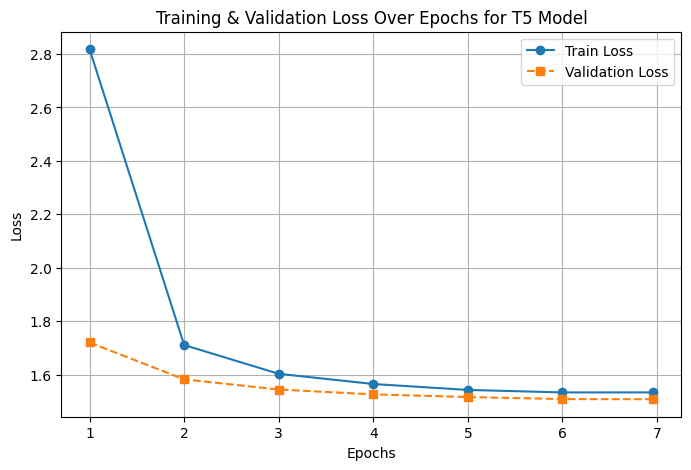

Unique labels in test_df['type'] (raw): ['Sarcasm' 'Idiom' 'Metaphor' 'Simile']

Checking label mapping for test dataset:
  Label: 'sarcasm' -> Mapped to: 0
  Label: 'idiom' -> Mapped to: 1
  Label: 'metaphor' -> Mapped to: 3
  Label: 'simile' -> Mapped to: 2

Final Mapped Labels (true_labels_text): {'Simile', 'Sarcasm', 'Idiom', 'Metaphor'}



Checking Predictions:
Unique True Labels: {'Simile', 'Sarcasm', 'Idiom', 'Metaphor'}
Unique Predictions: {'Simile', 'Sarcasm', 'Idiom', 'Metaphor'}

Valid Labels for Confusion Matrix: ['Simile', 'Sarcasm', 'Idiom', 'Metaphor']


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Accuracy for T5: 0.95

Accuracy Per Class:
  Sarcasm: 0.9827
  Idiom: 0.9200
  Simile: 1.0000
  Metaphor: 0.8508


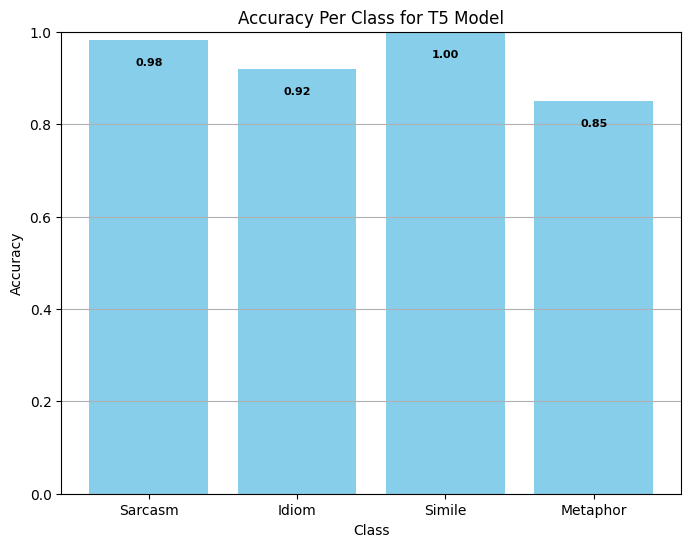

Classification Report of T5 Model:
              precision    recall  f1-score   support

     Sarcasm       0.87      0.92      0.89       250
       Idiom       0.92      0.85      0.88       248
      Simile       0.99      0.98      0.99       750
    Metaphor       0.95      1.00      0.98       250

    accuracy                           0.95      1498
   macro avg       0.93      0.94      0.94      1498
weighted avg       0.95      0.95      0.95      1498

Model Performance Metrics:
Accuracy: 0.9533
BLEURT: 0.8469
BERTScore (F1): 0.9924


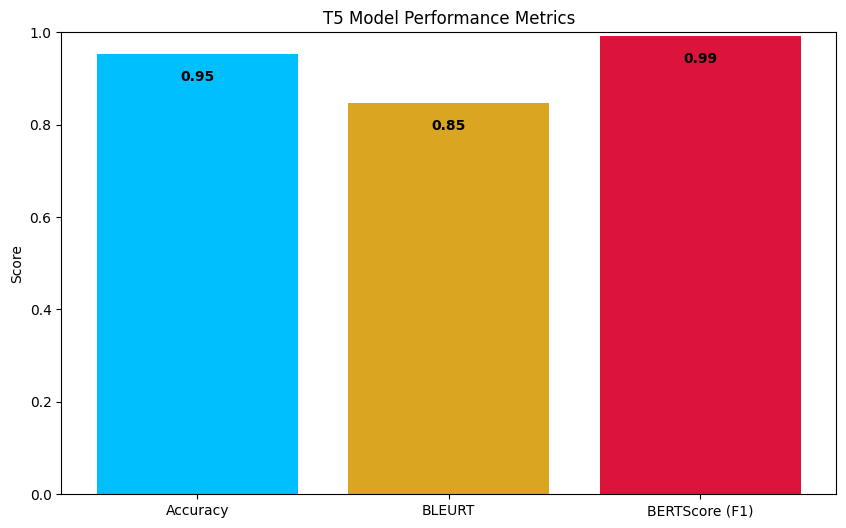

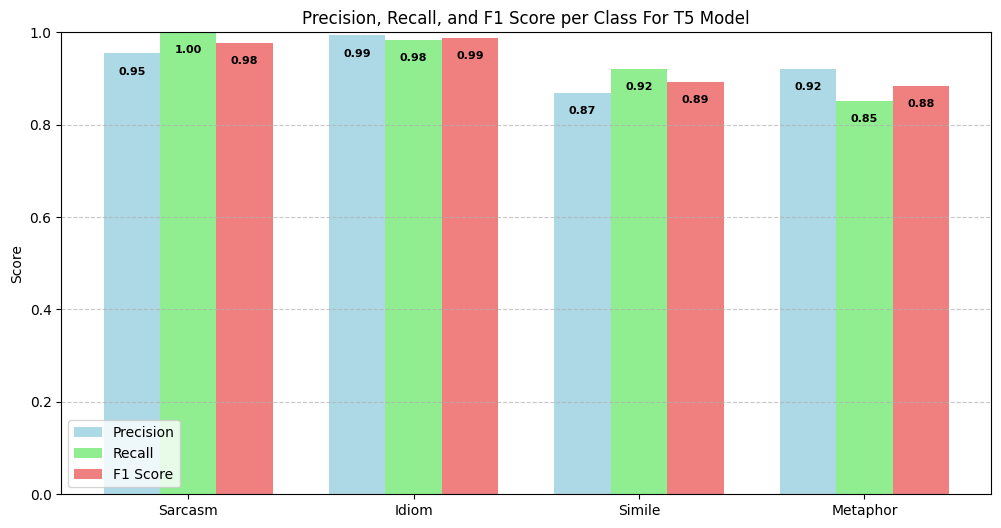

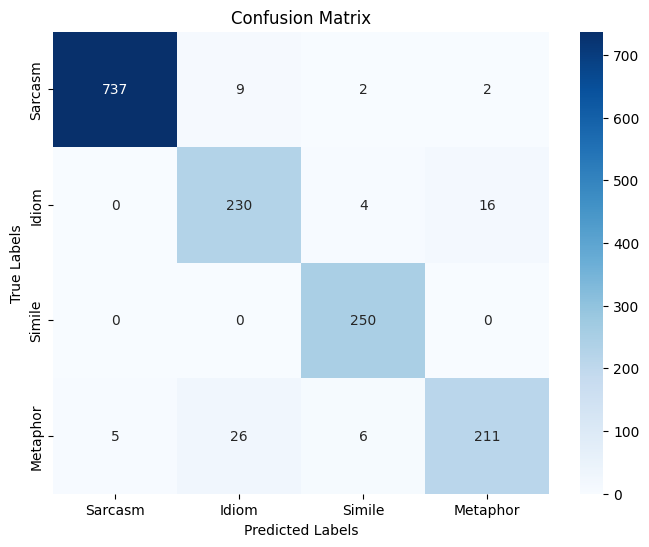

Total misclassified examples for T5 Model: 70/1498

List of Misclassified Examples:
1) Premise: I rob teenagers outside college to get money for drugs because I am a drug addict.
   Hypothesis: I'm a drug addict and to get money for drugs, I rob innocent teenagers who are just trying to get an education.
   True Label: Sarcasm
   Prediction: Idiom
--------------------------------------------------
2) Premise: The atmosphere was very peculiar and they all seem to hate each other's company and get along extremely poorly from the start.
   Hypothesis: The atmosphere was very peculiar and they all seem to get on like a house on fire.
   True Label: Idiom
   Prediction: Simile
--------------------------------------------------
3) Premise: She buried her knife in his chest shallowly.
   Hypothesis: She buried her knife in his chest all the way b> up to the hilt.
   True Label: Idiom
   Prediction: Metaphor
--------------------------------------------------
4) Premise: All of this stirred a d

,Premise,Hypothesis,True Label,Prediction
0,I rob teenagers outside college to get money f...,"I'm a drug addict and to get money for drugs, ...",Sarcasm,Idiom
1,The atmosphere was very peculiar and they all ...,The atmosphere was very peculiar and they all ...,Idiom,Simile
2,She buried her knife in his chest shallowly.,She buried her knife in his chest all the way ...,Idiom,Metaphor
3,All of this stirred a dullness for her.,All of this stirred an uncontrollable exciteme...,Metaphor,Idiom
4,That guy knows how to charm and manage people ...,This young man knows how to climb the social l...,Metaphor,Idiom
...,...,...,...,...
65,I am such a good person that others are easily...,I am the good shepherd and I lay down my life ...,Metaphor,Idiom
66,It did not appear to him him that she is not a...,It appeared to him that she had betrayed him.,Metaphor,Idiom
67,People that flake out like that just have no r...,People that flake out like that just have the ...,Sarcasm,Idiom
68,She began to compete against her sister for th...,She began to jockey for position with her sister.,Idiom,Metaphor


In [ ]:
#Loading T5 model and tokenizer
t5_model_name="t5-base"
t5_tokenizer=T5Tokenizer.from_pretrained(t5_model_name)
t5_model=T5ForConditionalGeneration.from_pretrained(t5_model_name)

#Defining label mapping
text_to_type={"Sarcasm": 0, "Idiom": 1, "Simile": 2, "Metaphor": 3}
type_to_text={v: k for k, v in text_to_type.items()}  #Reverse mapping

#Defining a function to prepare data for T5
def prepare_t5_data(dataset):
    """
    Convert dataset into T5-friendly input format.

    Args:
        dataset (pd.DataFrame): DataFrame containing 'premise', 'hypothesis', and 'type'.

    Returns:
        dict: Dictionary with 'input_text' and 'target_text'.
    """
    #Format input for T5 (Premise+Hypothesis)
    inputs=[f"Classify: {p} Hypothesis: {h}" for p, h in zip(dataset["premise"], dataset["hypothesis"])]

    #Converting string labels to text labels
    targets=[type_to_text[text_to_type[t]] for t in dataset["type"]]

    return {"input_text": inputs, "target_text": targets}

#Applying formatting to datasets
t5_train_data=prepare_t5_data(flute_train)
t5_val_data=prepare_t5_data(flute_val)
t5_test_data=prepare_t5_data(test_df)

#Defining a function to Clean T5 Data
def clean_t5_data(dataset):
    """
    Remove empty or corrupted samples from T5 dataset.

    Args:
        dataset (dict): Dictionary with input_text and target_text.

    Returns:
        dict: Cleaned dataset with valid inputs and targets.
    """
    cleaned_inputs=[]
    cleaned_targets=[]

    for input_text, target_text in zip(dataset["input_text"], dataset["target_text"]):
        if  input_text.strip() and target_text.strip():
          cleaned_inputs.append(input_text.strip())
          cleaned_targets.append(target_text.strip())

    print(f"Cleaned dataset: {len(cleaned_inputs)} valid samples (Removed {len(dataset['input_text'])-len(cleaned_inputs)} empty samples)")
    return {"input_text": cleaned_inputs, "target_text": cleaned_targets}

#Apply cleaning before tokenization
t5_train_data=clean_t5_data(t5_train_data)
t5_val_data=clean_t5_data(t5_val_data)
t5_test_data=clean_t5_data(t5_test_data)

#Defining a function to Tokenize Data for T5
def tokenize_t5_data(dataset, tokenizer, max_input_length=128, max_target_length=16):
    """
    Tokenizes input and target text for T5.

    Args:
        dataset (dict): Dictionary with input_text and target_text.
        tokenizer (T5Tokenizer): T5 tokenizer.
        max_input_length (int): Maximum token length for input.
        max_target_length (int): Maximum token length for target.

    Returns:
        dict: Tokenized inputs and labels.
    """
    #Tokenizing inputs (Premise+Hypothesis)
    model_inputs=tokenizer(
        dataset["input_text"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    #Tokenizing targets (Output labels)
    labels=tokenizer(
        dataset["target_text"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )["input_ids"]

    #Clone and detach labels to prevent in-place modification errors
    labels=labels.clone().detach().to(dtype=torch.long)

    #Replace padding token id with -100 to ignore it in loss computation
    labels[labels==tokenizer.pad_token_id]=-100

    #Ensuring decoder_input_ids do not contain -100
    decoder_input_ids=torch.cat(
        [torch.full((labels.shape[0], 1), tokenizer.pad_token_id, dtype=torch.long), labels[:, :-1]], dim=1
    )
    decoder_input_ids=torch.where(decoder_input_ids==-100, tokenizer.pad_token_id, decoder_input_ids)

    model_inputs["labels"]=labels
    model_inputs["decoder_input_ids"]=decoder_input_ids.to(dtype=torch.long)

    return model_inputs

#Applying tokenization
train_t5=Dataset.from_dict(tokenize_t5_data(t5_train_data, t5_tokenizer))
val_t5=Dataset.from_dict(tokenize_t5_data(t5_val_data, t5_tokenizer))
test_t5=Dataset.from_dict(tokenize_t5_data(t5_test_data, t5_tokenizer))

#Converting to pyTorch format
train_t5.set_format(type="torch")
val_t5.set_format(type="torch")
test_t5.set_format(type="torch")

#Ensuring no previous checkpoint interferes
if os.path.exists("./results/t5-base"):
    shutil.rmtree("./results/t5-base")  #Removing previous results directory

#Defining training arguments with gradient clipping
t5_training_args=Seq2SeqTrainingArguments(
    output_dir="./results/t5-base",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.02,
    save_total_limit=3,
    logging_dir="./logs/t5-base",
    load_best_model_at_end=False,
    seed=101,
    predict_with_generate=True,  #Enabling text generation
    fp16=False,
    gradient_checkpointing=True,
    gradient_accumulation_steps=2,
    optim="adamw_torch",         #Better stability
    label_smoothing_factor=0.1,  #Preventing overconfidence
    generation_max_length=16,    #Avoiding long outputs
    logging_steps=50,            #Reducing logging frequency
    max_grad_norm=1.0            #Gradient clipping to prevent NaN errors
)

#Defining trainer with properly tokenized dataset
t5_trainer=Seq2SeqTrainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    tokenizer=t5_tokenizer,
)

#Enabling full CUDA debugging
torch.autograd.set_detect_anomaly(True)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

#Run training with error handling
try:
    t5_trainer.train()
except RuntimeError as e:
    print("CUDA Runtime Error Detected!")
    print(e)
    raise  #Printing full error traceback

#Extracting loss history from trainer
train_loss=[]
val_loss=[]
epochs=[]

for log in t5_trainer.state.log_history:
    if "epoch" in log:
        current_epoch=log["epoch"]
        if current_epoch not in epochs:
            epochs.append(current_epoch)  #Append the epoch number only once
        if "loss" in log:  #Training loss
            train_loss.append(log["loss"])
        if "eval_loss" in log:  #Validation loss
            val_loss.append(log["eval_loss"])

#Synchronizing data lengths
min_length=min(len(epochs), len(train_loss), len(val_loss))
epochs=epochs[:min_length]
train_loss=train_loss[:min_length]
val_loss=val_loss[:min_length]

#Converting to dataFrame
df_loss=pd.DataFrame({
    "Epoch": epochs,
    "Train Loss": train_loss,
    "Validation Loss": val_loss
})

#Debugging dataFrame
print("Loss History DataFrame:")
print(df_loss)

#Ploting training and validation loss
plt.figure(figsize=(8,5))
plt.plot(df_loss["Epoch"], df_loss["Train Loss"], marker="o", linestyle="-", label="Train Loss")
plt.plot(df_loss["Epoch"], df_loss["Validation Loss"], marker="s", linestyle="--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs for T5 Model")
plt.legend()
plt.grid(True)
plt.show()

#Loading evaluation metrics
bleurt_metric=load("bleurt", "bleurt-large-512")
bertscore_metric=load("bertscore")

#Debugging unique labels in test dataset
print("Unique labels in test_df['type'] (raw):", test_df["type"].unique())

#Converting series of the labels to lists before mapping
test_types_list=[label.strip().lower() for label in test_df["type"]]

#Debugging individual label mapping
print("\nChecking label mapping for test dataset:")
for label in set(test_types_list):
    mapped_label=text_to_type.get(label.capitalize(), "Unknown")
    print(f"  Label: '{label}' -> Mapped to: {mapped_label}")

#Correcting mapping for true labels
true_labels_text=[type_to_text[text_to_type[label.capitalize()]] if label.capitalize() in text_to_type else "Unknown" for label in test_types_list]

#Debugging the mapped labels
print("\nFinal Mapped Labels (true_labels_text):", set(true_labels_text))

#Ensuring no "Unknown" labels
if "Unknown" in true_labels_text:
    raise ValueError("Error: 'Unknown' labels detected. Check label mapping.")

#Generating predictions
t5_predictions=t5_trainer.predict(test_t5)
decoded_preds=t5_tokenizer.batch_decode(t5_predictions.predictions, skip_special_tokens=True)

#Debugging outputs
print("\nChecking Predictions:")
print("Unique True Labels:", set(true_labels_text))
print("Unique Predictions:", set(decoded_preds))

#Ensuring valid labels for confusion matrix
valid_labels=list(set(true_labels_text).intersection(text_to_type.keys()))

#Debugging valid labels
print("\nValid Labels for Confusion Matrix:", valid_labels)

#Handling empty valid labels case
if not valid_labels:
    print("\nDebugging: Why are valid_labels empty?")
    print("Expected Labels (text_to_type.keys()):", set(text_to_type.keys()))
    print("True Labels from Testing:", set(true_labels_text))
    raise ValueError("No valid labels found for the confusion matrix. Check label mappings and predictions.")

#Calculating BLEURT score
bleurt_scores=bleurt_metric.compute(predictions=decoded_preds, references=true_labels_text)["scores"]
avg_bleurt_score=sum(bleurt_scores)/len(bleurt_scores)

#Calculating BERTScore
bertscore_results=bertscore_metric.compute(
    predictions=decoded_preds, references=true_labels_text, lang="en"
)
avg_bertscore_f1=sum(bertscore_results["f1"])/len(bertscore_results["f1"])

#Calculating accuracy
overall_accuracy=accuracy_score(true_labels_text, decoded_preds)
print(f"Overall Accuracy for T5: {overall_accuracy:.2f}")

#Defining ordered labels explicitly
ordered_labels=["Sarcasm", "Idiom", "Simile", "Metaphor"]

#Calculating accuracy per class
accuracy_per_class={}
for label in ordered_labels:
    total=sum([1 for true_label in true_labels_text if true_label==label])
    correct=sum(
        [
            1
            for true_label, pred in zip(true_labels_text, decoded_preds)
            if true_label==label and pred==label
        ]
    )
    accuracy_per_class[label]=correct/total if total>0 else 0.0

#Debugging accuracy per class
print("\nAccuracy Per Class:")
for label, acc in accuracy_per_class.items():
    print(f"  {label}: {acc:.4f}")

#Converting accuracy per class into a dataframe for easy visualization
accuracy_df=pd.DataFrame({
    "Class": list(accuracy_per_class.keys()),
    "Accuracy": list(accuracy_per_class.values())
})

#Plotting accuracy per class
plt.figure(figsize=(8,6))
bars=plt.bar(accuracy_df["Class"], accuracy_df["Accuracy"], color="skyblue")
plt.title("Accuracy Per Class for T5 Model")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis="y")

#Adding values inside each bar
for bar in bars:
    height=bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height-0.05,f"{height:.2f}",
             ha="center", va="center", color="black", fontsize=8, fontweight="bold")

plt.show()

#Classification report
class_report=classification_report(true_labels_text, decoded_preds, output_dict=True)

#Getting the string report
string_report=classification_report(true_labels_text, decoded_preds, target_names=ordered_labels)
print(f"Classification Report of T5 Model:\n{string_report}")

#Confusion matrix
conf_matrix=confusion_matrix(true_labels_text, decoded_preds, labels=ordered_labels)

#Precision, Recall, F1 Score
precision, recall, f1_score, _=precision_recall_fscore_support(
    true_labels_text, decoded_preds, average=None, labels=valid_labels
)

#Misclassified examples
misclassified=[]
for i in range(len(true_labels_text)):
    if true_labels_text[i]!=decoded_preds[i]:
        misclassified.append({
            "Premise": test_df.iloc[i]["premise"],
            "Hypothesis": test_df.iloc[i]["hypothesis"],
            "True Label": true_labels_text[i],
            "Prediction": decoded_preds[i]
        })

#Converting model performance into a dictionary
model_performance={
    "Accuracy": overall_accuracy,
    "BLEURT": avg_bleurt_score,
    "BERTScore (F1)": avg_bertscore_f1
}

#Displaying model performance dictionary
print("Model Performance Metrics:")
for key, value in model_performance.items():
    print(f"{key}: {value:.4f}")

#Plotting Accuracy, BLEURT, and BERTScore
plt.figure(figsize=(10,6))
bars=plt.bar(model_performance.keys(), model_performance.values(), color=["#00BFFF", "#DAA520", "#DC143C"]) #Deep Sky Blue, Goldenrod, Crimson
plt.title("T5 Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0,1)

#Adding values inside each bar
for bar in bars:
    height=bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
             ha="center", va="center", color="black", fontsize=10, fontweight="bold")

plt.show()

#Plotting Precision, Recall, F1 Score per Class
metrics_df=pd.DataFrame({
    "Class": list(text_to_type.keys()),
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
})

colors=["lightblue", "lightgreen", "lightcoral"]

x=np.arange(len(metrics_df["Class"]))  #Class positions
bar_width=0.25
plt.figure(figsize=(12,6))

#Plotting each metric
for i, metric in enumerate(["Precision", "Recall", "F1 Score"]):
    bars=plt.bar(
        x+i*bar_width,
        metrics_df[metric],
        bar_width,
        label=metric,
        color=colors[i]
    )

    #Adding values inside the bars
    for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="bottom", fontsize=8, fontweight="bold")

#Formatting the plot
plt.xticks(x+bar_width, metrics_df["Class"], ha="center")
plt.title("Precision, Recall, and F1 Score per Class For T5 Model")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

#Confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=ordered_labels, yticklabels=ordered_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Printing misclassified examples
print(f"Total misclassified examples for T5 Model: {len(misclassified)}/{len(true_labels_text)}")
print("\nList of Misclassified Examples:")
for i, example in enumerate(misclassified[:5]):  #Printing first 5 misclassified examples
    print(f"{i+1}) Premise: {example['Premise']}")
    print(f"   Hypothesis: {example['Hypothesis']}")
    print(f"   True Label: {example['True Label']}")
    print(f"   Prediction: {example['Prediction']}")
    print("-"*50)

#Displaying misclassified examples as dataFrame
misclassified_df=pd.DataFrame(misclassified)
print("\nMisclassified Examples:")
display(misclassified_df)

### **Comparing the Results of T5 with ROBERTA and BERT Models**

In [ ]:
#Uploading the files of Roberta_Bert_results
uploaded=files.upload()

#Checking if the files are uploaded
print("Uploaded Files:", uploaded.keys())

#Printing class-wise accuracy
with open("class_wise_accuracy.json", "r") as f:
    class_wise_accuracy=json.load(f)

print("\nClass-Wise Accuracy Data:")
print(json.dumps(class_wise_accuracy, indent=4))

#Printing precision, recall, and F1-score
with open("precision_recall_f1.json", "r") as f:
    precision_recall_f1=json.load(f)

print("\nPrecision, Recall, and F1 Score Data:")
print(json.dumps(precision_recall_f1, indent=4))

#Printing performance metrics
performance_df_loaded=pd.read_csv("performance_metrics.csv")

print("\nPerformance Metrics Data:")
display(performance_df_loaded)

Saving performance_metrics.csv to performance_metrics.csv
Saving precision_recall_f1.json to precision_recall_f1.json
Saving class_wise_accuracy.json to class_wise_accuracy.json
Uploaded Files: dict_keys(['performance_metrics.csv', 'precision_recall_f1.json', 'class_wise_accuracy.json'])

Class-Wise Accuracy Data:
{
    "roberta-base": {
        "0": 0.9973333333333333,
        "1": 0.908,
        "2": 0.992,
        "3": 0.9274193548387096
    },
    "bert-base-uncased": {
        "0": 0.9906666666666667,
        "1": 0.928,
        "2": 0.992,
        "3": 0.9354838709677419
    }
}

Precision, Recall, and F1 Score Data:
{
    "roberta-base": {
        "Precision": [
            0.9933598937583001,
            0.9537815126050421,
            0.9538461538461539,
            0.9311740890688259
        ],
        "Recall": [
            0.9973333333333333,
            0.908,
            0.992,
            0.9274193548387096
        ],
        "F1 Score": [
            0.9953426480372588

,Model,Accuracy,BLEURT,BERTScore F1
0,roberta-base,0.969960,0.960581,0.994075
1,bert-base-uncased,0.971295,0.964045,0.994310



Class-Wise Accuracy Table:
+---+----------+--------+---------+--------+
|   |  Class   |   T5   | Roberta |  Bert  |
+---+----------+--------+---------+--------+
| 0 | Sarcasm  | 0.9827 | 0.9973  | 0.9907 |
| 1 |  Idiom   |  0.92  |  0.908  | 0.928  |
| 2 |  Simile  |  1.0   |  0.992  | 0.992  |
| 3 | Metaphor | 0.8508 | 0.9274  | 0.9355 |
+---+----------+--------+---------+--------+


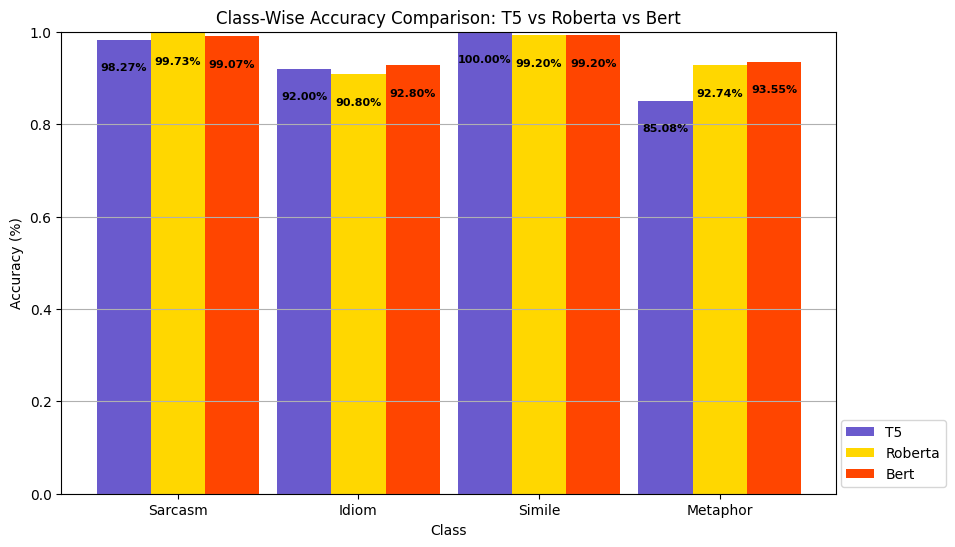


Precision, Recall, F1-score comparison Table:
+---+----------+--------------+-----------+-------------+-------------------+----------------+------------------+----------------+-------------+---------------+
|   |  Class   | T5 Precision | T5 Recall | T5 F1 Score | Roberta Precision | Roberta Recall | Roberta F1 Score | Bert Precision | Bert Recall | Bert F1 Score |
+---+----------+--------------+-----------+-------------+-------------------+----------------+------------------+----------------+-------------+---------------+
| 0 | Sarcasm  |    0.9933    |  0.9827   |   0.9879    |      0.9934       |     0.9973     |      0.9953      |     0.9973     |   0.9907    |     0.994     |
| 1 |  Idiom   |    0.8679    |   0.92    |   0.8932    |      0.9538       |     0.908      |      0.9303      |     0.9431     |    0.928    |    0.9355     |
| 2 |  Simile  |    0.9542    |    1.0    |   0.9766    |      0.9538       |     0.992      |      0.9725      |     0.9841     |    0.992    |    

<Figure size 1200x600 with 0 Axes>

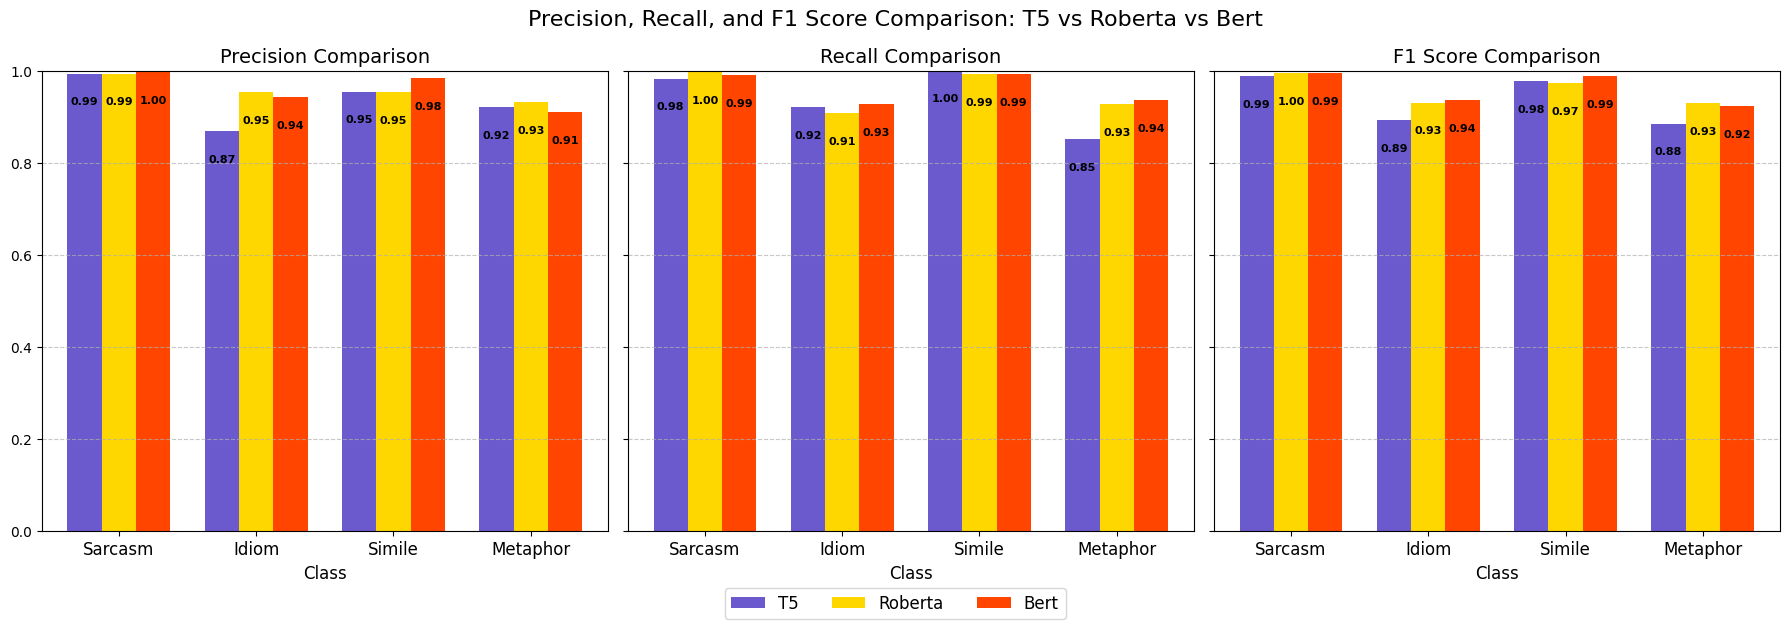


Performance Metrics Comparison Table:
+---+--------------+--------+---------+--------+
|   |    Metric    |   T5   | Roberta |  Bert  |
+---+--------------+--------+---------+--------+
| 0 |   Accuracy   | 0.9533 |  0.97   | 0.9713 |
| 1 |    BLEURT    | 0.8469 | 0.9606  | 0.964  |
| 2 | BERTScore F1 | 0.9924 | 0.9941  | 0.9943 |
+---+--------------+--------+---------+--------+


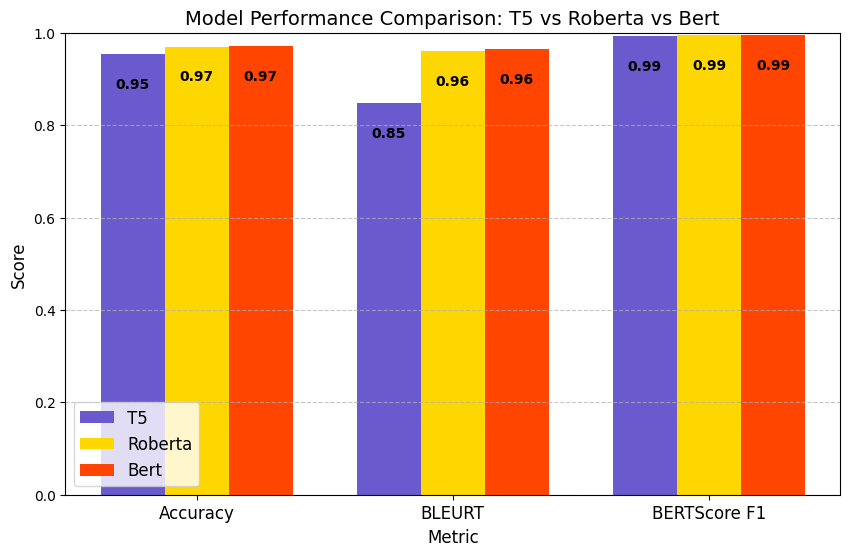

In [ ]:
#Class-wise accuracy comparison of the models
#Mapping numerical class labels to actual class names
label_mapping={"0": "Sarcasm", "1": "Idiom", "2": "Simile", "3": "Metaphor"}

#Ensuring ordered_labels is defined
ordered_labels=["Sarcasm", "Idiom", "Simile", "Metaphor"]

#Creating dataframe for class-wise accuracy
class_accuracy_df=pd.DataFrame({
    "Class": ordered_labels,
    "T5": [accuracy_per_class.get(cls, 0) for cls in ordered_labels],
    "Roberta": [class_wise_accuracy["roberta-base"].get(str(idx), 0) for idx in ["0", "1", "2", "3"]],
    "Bert": [class_wise_accuracy["bert-base-uncased"].get(str(idx), 0) for idx in ["0", "1", "2", "3"]],
})
class_accuracy_df.iloc[:, 1:]=class_accuracy_df.iloc[:, 1:].applymap(lambda x: round(x,4))

#Class-wise accuracy comparison table
print("\nClass-Wise Accuracy Table:")
print(tabulate(class_accuracy_df, headers="keys", tablefmt="pretty"))

#Class-wise accuracy comparison plot
bar_width=0.3
x=np.arange(len(class_accuracy_df["Class"]))
plt.figure(figsize=(10,6))

#Ploting bars for each model
bars_t5=plt.bar(x-bar_width, class_accuracy_df["T5"], width=bar_width, label="T5", color="#6A5ACD")  #Slate Blue
bars_roberta=plt.bar(x, class_accuracy_df["Roberta"], width=bar_width, label="Roberta", color="#FFD700")  #Gold
bars_bert=plt.bar(x+bar_width, class_accuracy_df["Bert"], width=bar_width, label="Bert", color="#FF4500")  #Orange Red

#Adding percentage values inside the bars
for bars in [bars_t5, bars_roberta, bars_bert]:
    for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height*100:.2f}%",
                 ha="center", va="top", fontsize=8, color="black", fontweight="bold")

plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Class-Wise Accuracy Comparison: T5 vs Roberta vs Bert")
plt.xticks(ticks=x, labels=class_accuracy_df["Class"])
plt.ylim(0,1)
plt.legend(loc="lower right", bbox_to_anchor=(1.15,0))
plt.grid(axis="y")
plt.show()

#Precision, Recall, F1-score comparison of the models
#Extracting Precision, Recall, and F1-score for T5 from class_report
t5_metrics={
    label:{
        "Precision": class_report[label]["precision"],
        "Recall": class_report[label]["recall"],
        "F1 Score": class_report[label]["f1-score"]
    }
    for label in ordered_labels
}

#Adding T5 model's metrics to the dictionary
precision_recall_f1["t5-base"]=t5_metrics

#Assigning class-wise values for Roberta
precision_recall_f1["roberta-base"]={
    ordered_labels[i]: {
        "Precision": precision_recall_f1["roberta-base"]["Precision"][i],
        "Recall": precision_recall_f1["roberta-base"]["Recall"][i],
        "F1 Score": precision_recall_f1["roberta-base"]["F1 Score"][i]
    }
    for i in range(len(ordered_labels))
}

#Assigning class-wise values for BERT
precision_recall_f1["bert-base-uncased"]={
    ordered_labels[i]: {
        "Precision": precision_recall_f1["bert-base-uncased"]["Precision"][i],
        "Recall": precision_recall_f1["bert-base-uncased"]["Recall"][i],
        "F1 Score": precision_recall_f1["bert-base-uncased"]["F1 Score"][i]
    }
    for i in range(len(ordered_labels))
}

#Creating dataframe for comparing
comparison_df=pd.DataFrame({
    "Class": ordered_labels,
    "T5 Precision": [precision_recall_f1["t5-base"][cls]["Precision"] for cls in ordered_labels],
    "T5 Recall": [precision_recall_f1["t5-base"][cls]["Recall"] for cls in ordered_labels],
    "T5 F1 Score": [precision_recall_f1["t5-base"][cls]["F1 Score"] for cls in ordered_labels],

    "Roberta Precision": [precision_recall_f1["roberta-base"][cls]["Precision"] for cls in ordered_labels],
    "Roberta Recall": [precision_recall_f1["roberta-base"][cls]["Recall"] for cls in ordered_labels],
    "Roberta F1 Score": [precision_recall_f1["roberta-base"][cls]["F1 Score"] for cls in ordered_labels],

    "Bert Precision": [precision_recall_f1["bert-base-uncased"][cls]["Precision"] for cls in ordered_labels],
    "Bert Recall": [precision_recall_f1["bert-base-uncased"][cls]["Recall"] for cls in ordered_labels],
    "Bert F1 Score": [precision_recall_f1["bert-base-uncased"][cls]["F1 Score"] for cls in ordered_labels],
})
comparison_df.iloc[:, 1:]=comparison_df.iloc[:, 1:].applymap(lambda x: round(x,4))

#Precision, Recall, F1-score comparison table
print("\nPrecision, Recall, F1-score comparison Table:")
print(tabulate(comparison_df, headers="keys", tablefmt="pretty"))

#Precision, Recall, F1-score comparison plot
bar_width=0.25
x=np.arange(len(comparison_df["Class"]))
plt.figure(figsize=(12,6))

#Plotting bars for each model
colors=["#6A5ACD", "#FFD700", "#FF4500"]  #Slate Blue, Gold, Orange Red
fig, axes=plt.subplots(1,3,figsize=(18,6), sharey=True)

#Defining metric names and corresponding column names in the dataframe
metrics=["Precision", "Recall", "F1 Score"]
columns=[
    ["T5 Precision", "Roberta Precision", "Bert Precision"],
    ["T5 Recall", "Roberta Recall", "Bert Recall"],
    ["T5 F1 Score", "Roberta F1 Score", "Bert F1 Score"]
]

#Iterating through the three metrics and create subplots
for i, (metric, cols) in enumerate(zip(metrics, columns)):
    ax=axes[i]

    #Ploting bars for each model
    bars_t5=ax.bar(x-bar_width, comparison_df[cols[0]], width=bar_width, label="T5", color=colors[0])
    bars_roberta=ax.bar(x, comparison_df[cols[1]], width=bar_width, label="Roberta", color=colors[1])
    bars_bert=ax.bar(x+bar_width, comparison_df[cols[2]], width=bar_width, label="Bert", color=colors[2])

    #Adding values inside the bars
    for bars in [bars_t5, bars_roberta, bars_bert]:
      for bar in bars:
        height=bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="top", fontsize=8, color="black", fontweight="bold")

    #Formatting the plot
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df["Class"], fontsize=12)
    ax.set_xlabel("Class", fontsize=12)
    ax.set_title(f"{metric} Comparison", fontsize=14)
    ax.set_ylim(0,1)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

#Setting common labels
fig.suptitle("Precision, Recall, and F1 Score Comparison: T5 vs Roberta vs Bert", fontsize=16)
fig.legend(["T5", "Roberta", "Bert"], loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.tight_layout()
plt.show()

#Performance metrics of the models
#Extracting performance metrics for each model
performance_comparison_df=pd.DataFrame({
    "Metric": ["Accuracy", "BLEURT", "BERTScore F1"],
    "T5": [
        model_performance.get("Accuracy", 0),
        model_performance.get("BLEURT", 0),
        model_performance.get("BERTScore (F1)", model_performance.get("BERTScore", 0))
    ],
    "Roberta": [
        performance_df_loaded[performance_df_loaded["Model"]=="roberta-base"]["Accuracy"].values[0],
        performance_df_loaded[performance_df_loaded["Model"]=="roberta-base"]["BLEURT"].values[0],
        performance_df_loaded[performance_df_loaded["Model"]=="roberta-base"].iloc[0].get("BERTScore F1",
        performance_df_loaded[performance_df_loaded["Model"]=="roberta-base"].iloc[0].get("BERTScore", 0))
    ],
    "Bert": [
        performance_df_loaded[performance_df_loaded["Model"]=="bert-base-uncased"]["Accuracy"].values[0],
        performance_df_loaded[performance_df_loaded["Model"]=="bert-base-uncased"]["BLEURT"].values[0],
        performance_df_loaded[performance_df_loaded["Model"]=="bert-base-uncased"].iloc[0].get("BERTScore F1",
        performance_df_loaded[performance_df_loaded["Model"]=="bert-base-uncased"].iloc[0].get("BERTScore", 0))
    ],
})
performance_comparison_df.iloc[:, 1:]=performance_comparison_df.iloc[:, 1:].applymap(lambda x: round(x,4))

#Performance metrics comparison table
print("\nPerformance Metrics Comparison Table:")
print(tabulate(performance_comparison_df, headers="keys", tablefmt="pretty"))


#Performance metrics comparison plot
bar_width=0.25
x=np.arange(len(performance_comparison_df["Metric"]))
colors=["#6A5ACD", "#FFD700", "#FF4500"]  #Slate Blue, Gold, Orange Red
plt.figure(figsize=(10,6))

#Ploting bars for each model
bars_t5=plt.bar(x-bar_width, performance_comparison_df["T5"], width=bar_width, label="T5", color=colors[0])
bars_roberta=plt.bar(x, performance_comparison_df["Roberta"], width=bar_width, label="Roberta", color=colors[1])
bars_bert=plt.bar(x+bar_width, performance_comparison_df["Bert"], width=bar_width, label="Bert", color=colors[2])

#Adding values inside the bars
for bars in [bars_t5, bars_roberta, bars_bert]:
    for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="top", fontsize=10, color="black", fontweight="bold")

#Formatting the plot
plt.xticks(x, performance_comparison_df["Metric"], fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Model Performance Comparison: T5 vs Roberta vs Bert", fontsize=14)
plt.ylim(0,1)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()